# Amazon Appliances Reviews Text Classifier

### Introduction
This project aims to construct a text classifier that will predict if a product review is positive or negative based on the text of that review. The outline is as follows:
* Import JSON file and create a dataframe of the contents. 
* Preprocess the data.
* Split the dataset into training and testing sets.
* Intitialize the Tokenizer with parameters and padding. 
* Create sequential model featuring an Embedding layer, 2 bidirectional LSTM layers, a Dense layer and an output Dense layer.
* Visualize the results by plotting the accuracy and loss.
* Predict new reviews.

### The Dataset

For this notebook, I will be using the Amazon Appliances Reviews dataset. This dataset is a smaller subset of the original [Amazon Review dataset](https://nijianmo.github.io/amazon/index.html). 

For more information, please view the following:  
__Justifying recommendations using distantly-labeled reviews and fined-grained aspects__  
Jianmo Ni, Jiacheng Li, Julian McAuley   
_Empirical Methods in Natural Language Processing (EMNLP)_, 2019

### Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Viewing and Preparing the Data

In [2]:
import json

#Explore the structure of the dataset
with open('Appliances.json') as f:
    appliance_data = pd.read_json(f, lines=True)
    
appliance_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


The dataset contains a lot of information, but for this project I am only interested in the ratings and reviews. Instead of working with the entire dataset, I will create another dataset containing just the ratings and reviews. 

In [3]:
#Create a dataframe with just the rating and reviews.
select_data = appliance_data[['overall', 'reviewText']].copy()
select_data.head()

,overall,reviewText
0,5,Not one thing in this book seemed an obvious o...
1,5,I have enjoyed Dr. Alan Gregerman's weekly blo...
2,5,Alan Gregerman believes that innovation comes ...
3,5,"Alan Gregerman is a smart, funny, entertaining..."
4,5,"As I began to read this book, I was again remi..."


Now that I have the dataset I want, I will preprocess the data before using it in my model. 

In [4]:
#Rename the columns.
select_data.rename(columns={'overall': 'rating', 'reviewText': 'review'}, inplace=True)
select_data.head()

,rating,review
0,5,Not one thing in this book seemed an obvious o...
1,5,I have enjoyed Dr. Alan Gregerman's weekly blo...
2,5,Alan Gregerman believes that innovation comes ...
3,5,"Alan Gregerman is a smart, funny, entertaining..."
4,5,"As I began to read this book, I was again remi..."


In [5]:
#View the data type of the columns.
select_data.dtypes

rating     int64
review    object
dtype: object

In [6]:
#Change the data type of review column to string. 
select_data['review'] = select_data['review'].astype('string')
select_data.dtypes

rating             int64
review    string[python]
dtype: object

In [7]:
#Check for any missing values.
select_data.isna().sum()

rating      0
review    324
dtype: int64

In [8]:
#Remove rows with missing values. 
select_data = select_data.dropna()

#Check to make sure the missing data was removed. 
select_data.isna().sum()

rating    0
review    0
dtype: int64

Currently, the values in the ratings column range from 1-5. For efficiency, I will set positive reviews to have a value of 1 and negative reviews a value of 0. Ratings that have a value of 1 or 2 will be categorized as a negative review. Similarly, ratings that have a value of 3, 4, or 5 will be categorized as a positive review.

In [9]:
#Replace ratings with 0(neg) or 1(pos).
select_data['rating'] = select_data['rating'].replace([1, 2], 0)
select_data['rating'] = select_data['rating'].replace([3, 4, 5], 1)

In [10]:
#Looking at a sample of the data to make sure it contains 0 or 1.
print(select_data[50:100])

    rating                                             review
50       1            Exactly what I needed and priced right!
51       1  Very well made, Sturdy. It performs as adverti...
52       1                       did what it was intended for
53       1  I bought this cord as the power cord for the C...
54       1  easy to install.  just what I needed for my ne...
55       1  Used for my Bosch EV car charger so it is not ...
56       1  Due to the nature of this item there is really...
57       1  Worked perfect and was cheaper than the same t...
58       1  This allows you to switch from venting your dr...
59       1  The bands are quite useless.
The mesh is not f...
60       1  This was just what I was looking for. The serv...
61       1                                       Works great!
62       1  It is a good .put the heat in my house when ne...
63       1                            It was what I expected.
64       1                                        as expected
65      

In [11]:
#Taking a look at one of the reviews.
print(select_data['review'][0])

Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.

Alan Gregerman discusses the meaning of human interactions and the kinds of situations that tend to inspire original and/or clear thinking that leads to innovation. These things include how people communicate in certain situations such as when they are outside of their normal patterns.

Gregerman identifies the ingredients that make innovation more likely. This includes people being compelled to interact when they normally wouldn't, leading to serendipity. Sometimes the phenomenon will occur through collaboration, and sometimes by chance such as when an individual is away from home on travel.

I recommend this book for its common sense, its truth and the apparent mastery of the subject by the author.


In [12]:
#Remove new lines and extra spacing.
import re

select_data['review'] = select_data['review'].replace(r'\n', ' ', regex=True)

In [13]:
print(select_data['review'][0])

Not one thing in this book seemed an obvious original thought. However, the clarity with which this author explains how innovation happens is remarkable.  Alan Gregerman discusses the meaning of human interactions and the kinds of situations that tend to inspire original and/or clear thinking that leads to innovation. These things include how people communicate in certain situations such as when they are outside of their normal patterns.  Gregerman identifies the ingredients that make innovation more likely. This includes people being compelled to interact when they normally wouldn't, leading to serendipity. Sometimes the phenomenon will occur through collaboration, and sometimes by chance such as when an individual is away from home on travel.  I recommend this book for its common sense, its truth and the apparent mastery of the subject by the author.


### Splitting the Data into Training and Testing Sets
The dataset will be split using scikit-learn's train_test_split function. I will allocate 70% to the training set and 30% to the test set. In order to keep the same randomized numbers each time, I used the random_state parameter.

In [14]:
#Find the number of rows in the dataframe.
print(f"Total set: {select_data.shape[0]}")

#Split the data.
from sklearn.model_selection import train_test_split
train_ratings, test_ratings, train_reviews, test_reviews = train_test_split(select_data['rating'], select_data['review'], train_size=0.7, random_state=42)

#Viewing the shape of the data.
print("train_ratings.shape", train_ratings.shape, "train_reviews.shape", train_reviews.shape)
print("test_ratings.shape", test_ratings.shape, "test_reviews.shape", test_reviews.shape)

Total set: 602453
train_ratings.shape (421717,) train_reviews.shape (421717,)
test_ratings.shape (180736,) test_reviews.shape (180736,)


### Setting up the Tokenizer with Padding

In [15]:
#Define the parameters for the tokenizing and padding.
vocab_size = 10000
embedding_dim = 32
max_length = 100
padding_type = 'post'
trunc_type = 'post'
oov_tok = '<OOV>'

In [16]:
#Initialize the tokenizer.
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_reviews)

#Create word index to store words from the reviews.
word_index = tokenizer.word_index

#Train sequences and ratings.
train_seqs = tokenizer.texts_to_sequences(train_reviews)
train_padded = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)

#Test sequences and ratings. 
test_seqs = tokenizer.texts_to_sequences(test_reviews)
test_padded = pad_sequences(test_seqs, maxlen=max_length, truncating=trunc_type)

### Creating the Model

In [17]:
#Defining the model.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          164864    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 653377 (2.49 MB)
Trainable params: 653377 

In [19]:
num_epochs = 10
history = model.fit(
    train_padded,
    train_ratings,
    epochs=num_epochs,
    validation_data=(test_padded, test_ratings)
)

Epoch 1/10
13179/13179 [==============================] - 1307s 99ms/step - loss: 0.1604 - accuracy: 0.9342 - val_loss: 0.1324 - val_accuracy: 0.9461
Epoch 2/10
13179/13179 [==============================] - 1163s 88ms/step - loss: 0.1211 - accuracy: 0.9518 - val_loss: 0.1226 - val_accuracy: 0.9509
Epoch 3/10
13179/13179 [==============================] - 1253s 95ms/step - loss: 0.1072 - accuracy: 0.9582 - val_loss: 0.1194 - val_accuracy: 0.9526
Epoch 4/10
13179/13179 [==============================] - 1624s 123ms/step - loss: 0.0962 - accuracy: 0.9628 - val_loss: 0.1216 - val_accuracy: 0.9519
Epoch 5/10
13179/13179 [==============================] - 1401s 106ms/step - loss: 0.0858 - accuracy: 0.9672 - val_loss: 0.1261 - val_accuracy: 0.9504
Epoch 6/10
13179/13179 [==============================] - 1393s 106ms/step - loss: 0.0752 - accuracy: 0.9718 - val_loss: 0.1370 - val_accuracy: 0.9502
Epoch 7/10
13179/13179 [==============================] - 1506s 114ms/step - loss: 0.0649 - accur

### Visualizing the Results

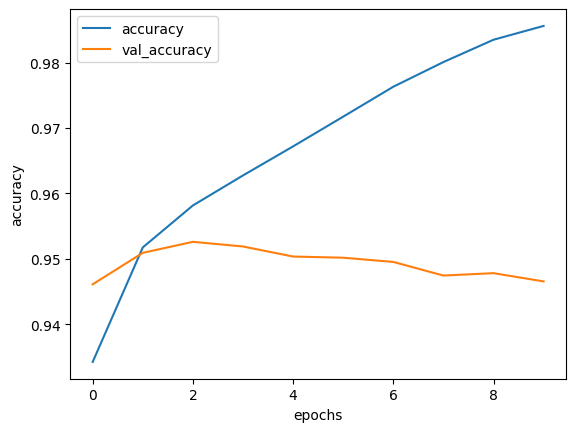

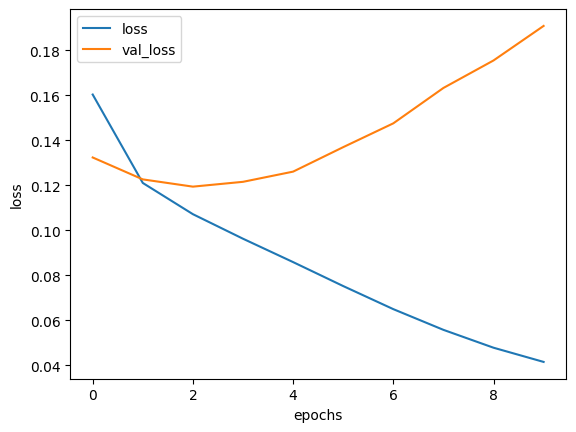

In [22]:
#Plotting the results of the model. 
import matplotlib.pyplot as plt

def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

### Classifying New Reviews

In [24]:
new_reviews = ["this product does not work, a waste of money", "awesome product, quick to setup"]
new_seqs = tokenizer.texts_to_sequences(new_reviews)
padded_seqs = pad_sequences(new_seqs, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded_seqs))

1/1 [==============================] - 1s 787ms/step
[[8.6332357e-04]
 [9.9926054e-01]]


The results are fairly accurate. The model predicted the correct classification, however, both of the results are pretty close to 0. It appears that the result for the negative review is closer to the true value of 0 compared to the positive review. Based on the plots above, the accuracy of the model increases, but when introduced to the test set the accuracy slowly decreases. Improvements can be made to the model as well as tuning the parameters of the tokenizer. 